### Table of Contents
* 1.) Exploratory Data Analysis
    * 1.1) Categorical Variables
    * 1.2) Numerical Variables
    * 1.3) Missing data
* 2.) Data Preparation
* 3.) Simple Model
* 4.) Hypertuning of Model
    * 4.1) Logistic Regression
    * 4.2) Random Forest
* 5.) Final Model

In [1]:
# Loading all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import datetime,time
import warnings
warnings.filterwarnings("ignore")

%cd D:\IPython Jupyter\HackerEarth

D:\IPython Jupyter\HackerEarth


### 1.) Exploratory Data Analysis

In [2]:
# Load Data
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')
df_train.shape, df_test.shape

((17521, 2395), (20442, 2394))

In [3]:
df_train.columns

Index(['Col1', 'Col2', 'Col3', 'Col4', 'Col5', 'Col6', 'Col7', 'Col8', 'Col9',
       'Col10',
       ...
       'Col2388', 'Col2389', 'Col2390', 'Col2391', 'Col2392', 'Col2393',
       'Col2394', 'Col2395', 'Col2396', 'Col2397'],
      dtype='object', length=2395)

In [4]:
# Unique IDs & Target Labels
df_train['Col1'].unique().shape, df_train['Col2'].unique().shape

((17521,), (2,))

In [5]:
df_train['Col2'].value_counts()

0    15760
1     1761
Name: Col2, dtype: int64

* Only 11% (1761) of data is labeled as 1 (delinquent)

#### 1.1) Categorical Variables

In [6]:
df_train.select_dtypes(include=np.object).columns

Index(['Col1', 'Col747', 'Col836'], dtype='object')

In [7]:
df_train.select_dtypes(include=np.object).isnull().sum()

Col1          0
Col747    16895
Col836    16897
dtype: int64

In [8]:
16895/df_train.shape[0]

0.9642714456937389

In [9]:
df_train[df_train['Col747'].isna()==False][['Col747','Col836']].drop_duplicates()

,Col747,Col836
10,-,-
37,0,0
310,0,-
369,1,0
535,-,NaN
1815,0,0
1881,5,0
3526,3,-
4848,1,-
5653,0,5


* Other than ID columns (Col1), there are 2 categorical variables Col747 & Col836 (due to "-" values). As because ~96% of data for these 2 columns are missing, so will drop them at later stage while treating missing values

#### 1.2) Numerical Variables
* data distribution: Skewness & Kurtosis

In [10]:
temp = pd.DataFrame({"Skewness": df_train.skew(), "Kurtosis": df_train.kurt()})

print(temp.shape)
temp.describe()

(2392, 2)


,Kurtosis,Skewness
count,2392.000000,2392.000000
mean,517.470121,7.164199
std,2090.725403,19.984721
min,-2.800000,-100.455422
25%,-0.524502,0.401519
50%,0.828794,0.988994
75%,20.617927,3.958020
max,16466.012143,126.672824


In [11]:
print("# columns with right Skewness:",temp[temp['Skewness'] > 1].shape[0])
print("# columns with left Skewness:",temp[temp['Skewness'] < -1].shape[0])

print("# columns with high peak Kurtosis:",temp[temp['Kurtosis'] > 1].shape[0])
print("# columns with plateau peak Kurtosis:",temp[temp['Kurtosis'] < -1].shape[0])

# columns with right Skewness: 1192
# columns with left Skewness: 29
# columns with high peak Kurtosis: 1186
# columns with plateau peak Kurtosis: 66


* **Skewness:** The skewness for a normal distribution is 0. Left skewed data has -ve value & right has +ve values.
    * If skewness is less than −1 or greater than +1, the distribution is highly skewed. If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed. If skewness is between −½ and +½, the distribution is approximately symmetric
    * Here in our data half of the variables are highly skewed

* **Kurtosis:** If the kurtosis is close to 0, then a normal distribution is often assumed.  These are called mesokurtic distributions.  If the kurtosis is less than zero, then the distribution is light tails and is called a platykurtic distribution.  If the kurtosis is greater than zero, then the distribution has heavier tails and is called a leptokurtic distribution.
    * Here in our data half of the variables are not normally distributed

#### 1.3) Missing data

In [12]:
total = df_train.isnull().sum().sort_values(ascending = False)
percentage = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending = False)
percentage = percentage*100
missing_data = pd.concat([total,percentage], axis = 1, keys=['Total','percentage'])

print("# missing Columns (>0%):",missing_data[missing_data['percentage']>0].shape[0])
print("# missing Columns (>40%):",missing_data[missing_data['percentage']>40].shape[0])
print("# missing Columns (>60%):",missing_data[missing_data['percentage']>60].shape[0])
print("# missing Columns (>80%):",missing_data[missing_data['percentage']>80].shape[0])

# missing Columns (>0%): 759
# missing Columns (>40%): 228
# missing Columns (>60%): 218
# missing Columns (>80%): 113


* 759 columns have at least one missing data point
* 228 columns have more than 40% of data missing (drop these data), and impute missing data in rest of the variables

### 2.) Data Preparation

In [13]:
# Combine Train+Test Data: Data Preparation
df_train.shape, df_test.shape

((17521, 2395), (20442, 2394))

In [14]:
df_test['Col2'] = 'NA'                                           # Adding test data's target variable as "NA"
df_com = df_train.append(df_test, ignore_index=True)
print(df_com.shape)

(37963, 2395)


In [15]:
# Categorical variables
df_com.select_dtypes(np.object).iloc[:,2:].columns

Index(['Col702', 'Col733', 'Col742', 'Col747', 'Col754', 'Col763', 'Col791',
       'Col813', 'Col822', 'Col831', 'Col836', 'Col843', 'Col852'],
      dtype='object')

* In combine data (Train + Test), 13 variables found to be as categorical variables, all because of some values have hyphen("-"). Also, more than 90% of data is missing in these variables.
* Let's drop variables with >50% missing values

In [16]:
# Drop variables with missing data >50%
# Drop ID column & target as well
df_com1 = df_com.loc[:,df_com.isnull().mean() < .5].drop(['Col1','Col2'],axis=1)
df_com1.shape

(37963, 2171)

In [17]:
# Check if still any categorical variable left after dropping missing variables
df_com1.select_dtypes(np.object).columns

Index([], dtype='object')

In [18]:
# Impute missing values: fill missing values with median column values (bcz 50% of variables are not normally distributed)

imputer = Imputer(strategy='median')
df_com2 = pd.DataFrame(imputer.fit_transform(df_com1.values))
df_com2.columns = df_com1.columns.to_list()

# count the number of NaN values in each column
print(df_com2.isnull().sum().sum())

df_com2.head()

0


,Col10,Col100,Col1000,Col1001,Col1002,Col1003,Col1004,Col1005,Col1006,Col1007,...,Col990,Col991,Col992,Col993,Col994,Col995,Col996,Col997,Col998,Col999
0,2.871509e+04,0.0,2.0,3.0,2.0,1.0,0.0,0.0,3.0,2.0,...,0.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,3.0
1,1.666974e+05,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,6.906324e+06,1.0,4.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,...,1.0,0.0,0.0,0.0,2.0,2.0,3.0,1.0,4.0,0.0
3,4.236612e+05,1.0,4.0,0.0,0.0,0.0,3.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,4.0,0.0
4,5.446532e+06,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,4.0,0.0,3.0,0.0,0.0,0.0


In [19]:
# Data Normalization
# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaler = RobustScaler()
df_com3 = pd.DataFrame(scaler.fit_transform(df_com2))
df_com3.columns = df_com2.columns.to_list()
df_com3.head()

,Col10,Col100,Col1000,Col1001,Col1002,Col1003,Col1004,Col1005,Col1006,Col1007,...,Col990,Col991,Col992,Col993,Col994,Col995,Col996,Col997,Col998,Col999
0,0.000876,0.0,0.285714,0.6,0.333333,0.166667,0.000000,0.000000,0.375,0.4,...,0.00,0.0,0.00,0.000000,0.166667,0.5,0.333333,0.166667,0.333333,0.5
1,0.005086,0.0,0.428571,0.2,0.000000,0.000000,0.166667,0.000000,0.000,0.0,...,0.00,0.0,0.00,0.000000,0.166667,0.0,0.000000,0.000000,0.166667,0.0
2,0.210696,0.1,0.571429,0.0,0.000000,0.000000,0.333333,0.333333,0.250,0.0,...,0.25,0.0,0.00,0.000000,0.333333,0.5,0.500000,0.166667,0.666667,0.0
3,0.012925,0.1,0.571429,0.0,0.000000,0.000000,0.500000,0.166667,0.375,0.0,...,0.00,0.0,0.00,0.000000,0.333333,0.5,0.000000,0.000000,0.666667,0.0
4,0.166161,0.1,0.571429,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.0,...,0.00,0.0,0.25,0.666667,0.666667,0.0,0.500000,0.000000,0.000000,0.0


### 3.) Simple Model

In [20]:
def simple_model(alg):

    # splitting data into training and validation set
    xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['Col2'].values.ravel(), random_state=42, test_size=0.2)
    model = alg
    model.fit(xtrain, ytrain) # training the model
#     prediction = model.predict_proba(xtest) # predicting on the validation set
#     prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
#     prediction_int = prediction_int.astype(np.int)

    print("f1_score:",f1_score(ytest, model.predict(xtest))) # calculating f1 score
    print("Accuracy on train data:",model.score(xtrain,ytrain))
    print("Accuracy on test data:",model.score(xtest,ytest))

In [21]:
train = df_com3.iloc[:17521,:]
test = df_com3.iloc[17521:,:]

In [22]:
algs = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),ExtraTreesClassifier(),AdaBoostClassifier(),GradientBoostingClassifier()]
algs_lst = ['LR','DTC','RFC','ETC','ABC','GBC']
for alg,l in zip(algs,algs_lst):
    print(l)
    simple_model(alg=alg)

LR
f1_score: 0.13778705636743216
Accuracy on train data: 0.9154537671232876
Accuracy on test data: 0.8821683309557775
DTC
f1_score: 0.2013605442176871
Accuracy on train data: 0.9929366438356164
Accuracy on test data: 0.8325249643366619
RFC
f1_score: 0.0717948717948718
Accuracy on train data: 0.9779537671232876
Accuracy on test data: 0.896718972895863
ETC
f1_score: 0.057291666666666664
Accuracy on train data: 0.9929366438356164
Accuracy on test data: 0.896718972895863
ABC
f1_score: 0.16143497757847533
Accuracy on train data: 0.9018978310502284
Accuracy on test data: 0.8932952924393723
GBC
f1_score: 0.1262135922330097
Accuracy on train data: 0.9137414383561644
Accuracy on test data: 0.8972895863052782


### 4.) Hypertuning of Model

In [27]:
# Defining model with different evaluation metrics
def model_evaluate(alg,th_val=0.5):
    s = time.time()
    train = df_com3.iloc[:17521,:]
    test = df_com3.iloc[17521:,:]

    xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['Col2'].values.ravel(), random_state=42, test_size=0.2)
    model = alg
    # C=0.9,penalty='l2', class_weight='balanced',random_state=29
    model.fit(xtrain, ytrain)
    print(model)

    # PREDICTION
    prediction = model.predict_proba(xtest)       # predicting on the validation set
    prediction_int = prediction[:,1] >= th_val    # if prediction is greater than or equal to 0.3 than 1 else 0
    ypred = prediction_int.astype(np.int)

    # F1-SCORE, ACCURACY
    print("f1_score:",f1_score(ytest, ypred))                       # calculating f1 score
    print("Accuracy on train data:",model.score(xtrain,ytrain))
    print("Accuracy on test data:",model.score(xtest,ytest))

    # CLASSIFICATION REPORT
    print(classification_report(ytest,ypred))

    # CONFUSION MATRIX
    print(pd.crosstab(ypred,ytest))

    # AUC & ROC
    ypred = model.predict_proba(xtest)[::,1]                 # predicting on the validation set
    auc = roc_auc_score(ytest, ypred)
    print("Area Under the Curve:",auc)
    fpr, tpr, thresholds = roc_curve(ytest, ypred)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate'), plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    # plt.savefig('Log_ROC')
    plt.show()

    e = time.time()
    print(e-s)

#### 4.1) Logistic Regression

In [28]:
s = time.time()

train = df_com3.iloc[:17521,:]
test = df_com3.iloc[17521:,:]
xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['Col2'].values.ravel(), random_state=42, test_size=0.2)
print(xtrain.shape)

model = LogisticRegression(penalty='l2',class_weight='balanced')
grid = {'C':[0.1,0.5,0.9]
#         'penalty':['l1','l2'],
#         'class_weight':['balanced']
       }
# cv = KFold(n_splits = 10, shuffle=True, random_state = 7)
clf = RandomizedSearchCV(model, grid, n_jobs=8, cv=None,scoring='roc_auc')
clf.fit(xtrain, ytrain)

e = time.time()
print(e-s)

(14016, 2171)
1002.6561298370361


In [30]:
clf.best_score_, clf.best_params_

(0.6705342847694009, {'C': 0.1})

In [32]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for m,s,p in zip(means,stds,params):
    print(m,s,p)

0.6705342847694009 0.00815712870764445 {'C': 0.1}
0.6465862354608748 0.009348602933324722 {'C': 0.5}
0.638806559523418 0.009453832086113667 {'C': 0.9}


LogisticRegression(C=0.9, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=29, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
f1_score: 0.2523240371845949
Accuracy on train data: 0.7438641552511416
Accuracy on test data: 0.6787446504992868
              precision    recall  f1-score   support

           0       0.93      0.69      0.80      3150
           1       0.17      0.54      0.25       355

    accuracy                           0.68      3505
   macro avg       0.55      0.62      0.52      3505
weighted avg       0.85      0.68      0.74      3505

col_0     0    1
row_0           
0      2189  165
1       961  190
Area Under the Curve: 0.6628039347194276


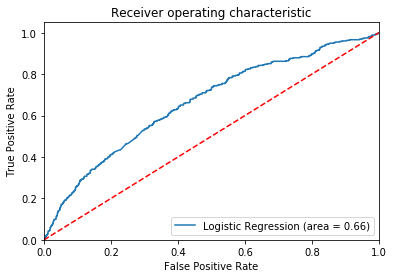

355.5143482685089


In [33]:
model_evaluate(LogisticRegression(C=0.9,penalty='l2',class_weight='balanced',random_state=29))

In [70]:
# Cross Validation
from sklearn.model_selection import cross_val_score, KFold

xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['Col2'].values.ravel(), random_state=42, test_size=0.2)
kfold = KFold(n_splits = 10, random_state = 7)
modelCV = LogisticRegression(C=0.9,penalty='l2',class_weight='balanced',random_state=29)
scoring = 'f1_macro'
results_train = cross_val_score(modelCV, xtrain, ytrain, scoring = scoring, cv = kfold)
results_test = cross_val_score(modelCV, xtest, ytest, scoring = scoring, cv = kfold)
print("10-fold cross validation average accuracy on train data: %.3f" % (results_train.mean()))
print("10-fold cross validation average accuracy on test data: %.3f" % (results_test.mean()))
print("results_train:",results_train)
print("results_test:",results_test)

10-fold cross validation average accuracy on train data: 0.544
10-fold cross validation average accuracy on test data: 0.533
results_train: [0.5504462  0.54153613 0.50448858 0.55744949 0.52753724 0.53087162
 0.53104885 0.53600492 0.56236165 0.59658208]
results_test: [0.51505941 0.55023908 0.5520362  0.60452015 0.53253208 0.52695182
 0.51496674 0.50300613 0.55477818 0.48065052]


#### 4.2) Random Forest

In [172]:
s = time.time()

n_estimators = [10, 50,100]
max_depth = [15, 20, 25]
min_samples_split = [10, 20, 30]
min_samples_leaf = [10, 20] 

train = df_com3.iloc[:17521,:]
xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['Col2'].values.ravel(), random_state=42, test_size=0.2)

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

model = RandomForestClassifier(random_state=29)
gridF = GridSearchCV(model, hyperF, verbose = 1,scoring='roc_auc', n_jobs = -1)
bestF = gridF.fit(xtrain, ytrain)

e = time.time()
print(e-s)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 11.8min finished


733.1345026493073


In [173]:
bestF.best_score_, bestF.best_params_

(0.7232990672607187,
 {'max_depth': 15,
  'min_samples_leaf': 20,
  'min_samples_split': 10,
  'n_estimators': 100})

In [174]:
means = bestF.cv_results_['mean_test_score']
stds = bestF.cv_results_['std_test_score']
params = bestF.cv_results_['params']
for m,s,p in zip(means,stds,params):
    print(m,s,p)

0.6852743307337466 0.007391312475788964 {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 15, 'n_estimators': 10}
0.71421864518855 0.008042311047792175 {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 15, 'n_estimators': 50}
0.7204251996126552 0.006544846137654559 {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 15, 'n_estimators': 100}
0.6852743307337466 0.007391312475788964 {'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 15, 'n_estimators': 10}
0.71421864518855 0.008042311047792175 {'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 15, 'n_estimators': 50}
0.7204251996126552 0.006544846137654559 {'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 15, 'n_estimators': 100}
0.6890879398800783 0.00628432888914376 {'min_samples_split': 30, 'min_samples_leaf': 10, 'max_depth': 15, 'n_estimators': 10}
0.7178922307459714 0.00816716869864517 {'min_samples_split': 30, 'min_samples_leaf': 10, 'max_depth': 15, 'n_estim

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=29, verbose=0, warm_start=False)
f1_score: 0.3107721639656816
Accuracy on train data: 0.8514554794520548
Accuracy on test data: 0.7937232524964337
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      3150
           1       0.23      0.46      0.31       355

    accuracy                           0.79      3505
   macro avg       0.58      0.65      0.59      3505
weighted avg       0.86      0.79      0.82      3505

col_0     0    1
row_0           
0      2619  192
1       531  

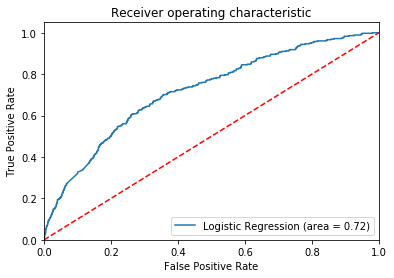

33.99060297012329


In [175]:
model_evaluate(RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=10, min_samples_split=10, 
                                      min_samples_leaf=20, random_state=29),th_val=0.5)

### 5.) Final Model

In [177]:
s = time.time()

train = df_com3.iloc[:17521,:]
test = df_com3.iloc[17521:,:]
ytrain = df_train['Col2'].values.ravel()
print(train.shape,test.shape,ytrain.shape)

# model = LogisticRegression(C=0.9,penalty='l2',class_weight='balanced',random_state=29)

model = RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=10, min_samples_split=10, 
                                      min_samples_leaf=20, random_state=29)

model.fit(train, ytrain)

(17521, 2171) (20442, 2171) (17521,)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=29, verbose=0, warm_start=False)

In [178]:
# Prediction
prediction = model.predict_proba(test)                   # predicting on the validation set
prediction_int = prediction[:,1] >= 0.608                # if prediction is greater than or equal to 0.6 than 1 else 0
prediction_int = prediction_int.astype(np.int)

df_sample_submission = pd.DataFrame()
df_sample_submission['Col1'] = df_test['Col1']
df_sample_submission['Col2'] = prediction_int

print(df_sample_submission.shape, '\n', df_sample_submission['Col2'].value_counts())

(20442, 2) 
 0    19443
1      999
Name: Col2, dtype: int64


In [179]:
df_sample_submission.to_csv('submission_file.csv',index=False)